In [1]:
# extras
import os
import glob
from datetime import datetime, timedelta

# data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#widgets
from ipywidgets import interact, widgets, VBox, HBox, Layout

# machine and deep learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten)


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:

cosmetics_event_1_df=pd.read_csv('/content/2020-Jan.csv')
cosmetics_event_2_df=pd.read_csv('/content/2020-Feb.csv')
cosmetics_event_10_df=pd.read_csv('/content/2019-Oct.csv')
cosmetics_event_11_df=pd.read_csv('/content/2019-Nov.csv')
cosmetics_event_12_df=pd.read_csv('/content/2019-Dec.csv')

In [4]:
cosmetics_event_combined_df = pd.concat([
    cosmetics_event_10_df,
    cosmetics_event_11_df,
    cosmetics_event_12_df,
    cosmetics_event_1_df,
    cosmetics_event_2_df
], ignore_index=True)

In [5]:
display(cosmetics_event_combined_df.head())
display(cosmetics_event_combined_df.shape)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203.0,1.487580e+18,NaN,runail,2.62,463240011.0,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353.0,1.487580e+18,NaN,runail,2.62,463240011.0,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589.0,2.151191e+18,NaN,lovely,13.48,429681830.0,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490.0,1.487580e+18,NaN,runail,2.62,463240011.0,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449.0,1.487580e+18,NaN,lovely,0.56,429681830.0,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


(4601064, 9)

### dropping user_id, category_id, and user_session since they are irrelevent
### converting event_time using pd.to_datetime()

In [6]:
cols_to_drop = ["user_id", "category_id", "user_session"]
cosmetics_event_combined_df.drop(columns=cols_to_drop, inplace=True)

cosmetics_event_combined_df['event_time'] = pd.to_datetime(cosmetics_event_combined_df['event_time'], errors='coerce')


display(cosmetics_event_combined_df.head())

,event_time,event_type,product_id,category_code,brand,price
0,2019-10-01 00:00:00+00:00,cart,5773203.0,NaN,runail,2.62
1,2019-10-01 00:00:03+00:00,cart,5773353.0,NaN,runail,2.62
2,2019-10-01 00:00:07+00:00,cart,5881589.0,NaN,lovely,13.48
3,2019-10-01 00:00:07+00:00,cart,5723490.0,NaN,runail,2.62
4,2019-10-01 00:00:15+00:00,cart,5881449.0,NaN,lovely,0.56


### checking basic info

In [7]:
display(cosmetics_event_combined_df.info())
display(cosmetics_event_combined_df.describe())
display(cosmetics_event_combined_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601064 entries, 0 to 4601063
Data columns (total 6 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     float64            
 3   category_code  object             
 4   brand          object             
 5   price          float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 210.6+ MB


None

,product_id,price
count,4.601063e+06,4.601063e+06
mean,5.484531e+06,8.583631e+00
std,1.302254e+06,1.943666e+01
min,3.752000e+03,-7.937000e+01
25%,5.724604e+06,2.060000e+00
50%,5.810145e+06,3.970000e+00
75%,5.856842e+06,7.140000e+00
max,5.926542e+06,3.277800e+02


,0
event_time,1
event_type,1
product_id,1
category_code,4524778
brand,1943686
price,1


### dropping category_code because more than 80 percent is nan

In [8]:
cosmetics_event_combined_df.drop(columns='category_code', inplace=True)
print(cosmetics_event_combined_df.isna().sum())

event_time          1
event_type          1
product_id          1
brand         1943686
price               1
dtype: int64


### we will leave brand for now and can group the missing in their own category later

### Dividing the time into months year and days to do time based analysis

In [9]:
cosmetics_event_combined_df['year'] = cosmetics_event_combined_df['event_time'].dt.year
cosmetics_event_combined_df['month'] = cosmetics_event_combined_df['event_time'].dt.month
cosmetics_event_combined_df['day'] = cosmetics_event_combined_df['event_time'].dt.day
cosmetics_event_combined_df['hour'] = cosmetics_event_combined_df['event_time'].dt.hour

 ### per month events plot

/tmp/ipython-input-2172838338.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cosmetics_event_combined_df['year_month'] = cosmetics_event_combined_df['event_time'].dt.to_period('M')


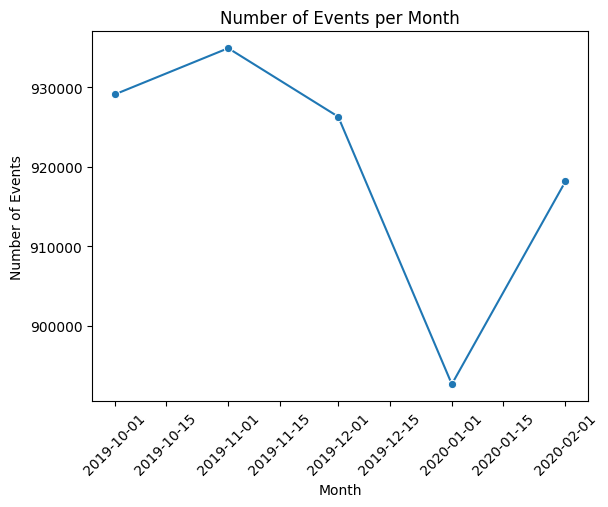

In [10]:
cosmetics_event_combined_df['year_month'] = cosmetics_event_combined_df['event_time'].dt.to_period('M')

monthly_events = cosmetics_event_combined_df.groupby('year_month').size().reset_index(name='count')
monthly_events['year_month'] = monthly_events['year_month'].dt.to_timestamp()

sns.lineplot(data=monthly_events, x='year_month', y='count', marker='o')
plt.title("Number of Events per Month")
plt.xlabel("Month")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.show()


### Hourly events plot

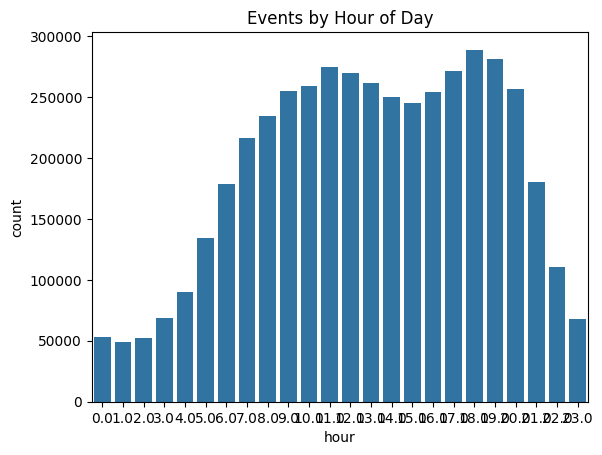

In [11]:
hourly_events = cosmetics_event_combined_df.groupby('hour').size().reset_index(name='count')
sns.barplot(data=hourly_events, x='hour', y='count')
plt.title("Events by Hour of Day")
plt.show()

### event type plot

/tmp/ipython-input-120517853.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cosmetics_event_combined_df, x='event_type', palette="Set2")


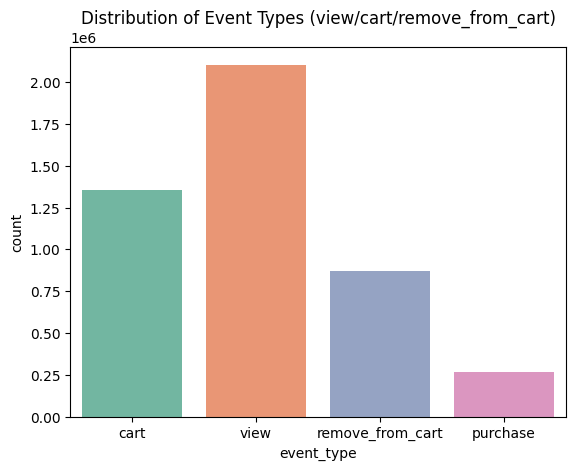

In [12]:
sns.countplot(data=cosmetics_event_combined_df, x='event_type', palette="Set2")
plt.title("Distribution of Event Types (view/cart/remove_from_cart)")
plt.show()

### brand type plot

/tmp/ipython-input-2919087386.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.index, y=top_brands.values, palette="coolwarm")


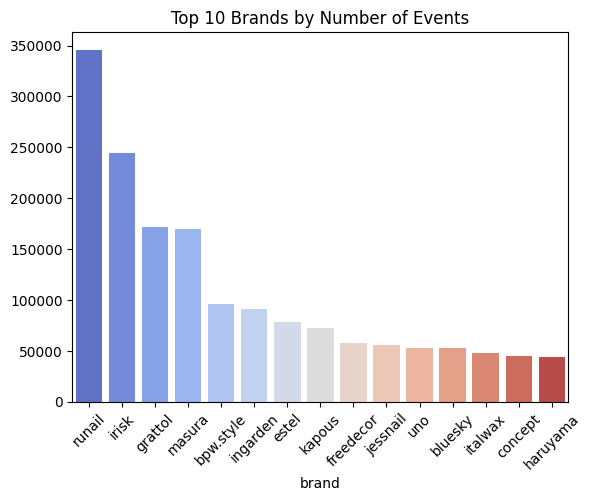

In [13]:
top_brands = cosmetics_event_combined_df['brand'].value_counts().head(15)
sns.barplot(x=top_brands.index, y=top_brands.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Brands by Number of Events")
plt.show()


### price outliers (boxplot & historgam)

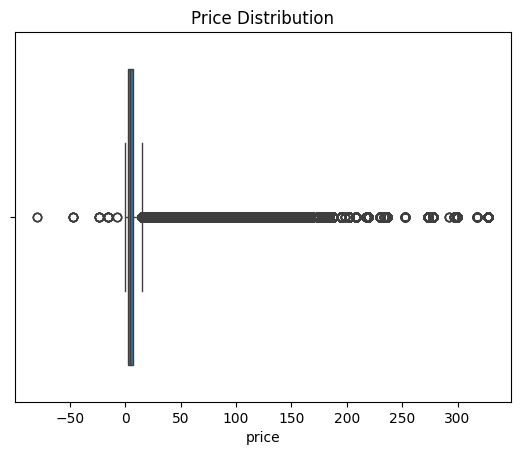

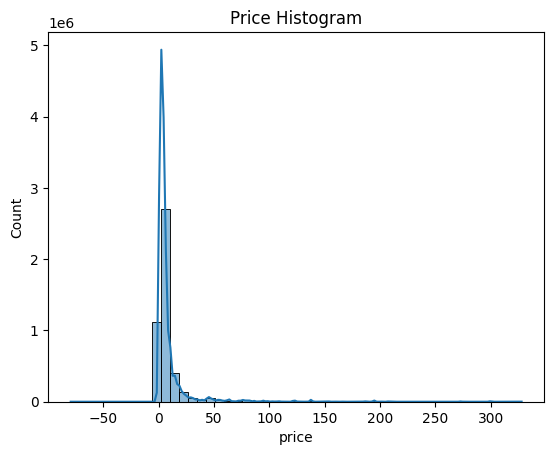

In [14]:
sns.boxplot(x=cosmetics_event_combined_df['price'])
plt.title("Price Distribution")
plt.show()

sns.histplot(cosmetics_event_combined_df['price'], bins=50, kde=True)
plt.title("Price Histogram")
plt.show()

### remove outliers

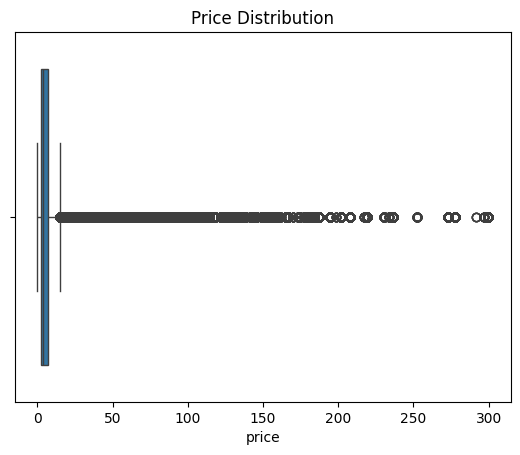

,event_time,event_type,product_id,brand,price,year,month,day,hour,year_month
0,2019-10-01 00:00:00+00:00,cart,5773203.0,runail,2.62,2019.0,10.0,1.0,0.0,2019-10
1,2019-10-01 00:00:03+00:00,cart,5773353.0,runail,2.62,2019.0,10.0,1.0,0.0,2019-10
2,2019-10-01 00:00:07+00:00,cart,5881589.0,lovely,13.48,2019.0,10.0,1.0,0.0,2019-10
3,2019-10-01 00:00:07+00:00,cart,5723490.0,runail,2.62,2019.0,10.0,1.0,0.0,2019-10
4,2019-10-01 00:00:15+00:00,cart,5881449.0,lovely,0.56,2019.0,10.0,1.0,0.0,2019-10
...,...,...,...,...,...,...,...,...,...,...
4601059,2020-02-06 19:00:40+00:00,cart,5822585.0,NaN,2.54,2020.0,2.0,6.0,19.0,2020-02
4601060,2020-02-06 19:00:40+00:00,view,5839676.0,masura,2.37,2020.0,2.0,6.0,19.0,2020-02
4601061,2020-02-06 19:00:40+00:00,view,5819226.0,ingarden,4.60,2020.0,2.0,6.0,19.0,2020-02
4601062,2020-02-06 19:00:41+00:00,view,5896418.0,jessnail,49.21,2020.0,2.0,6.0,19.0,2020-02


In [15]:
cosmetics_event_filtered = cosmetics_event_combined_df[(cosmetics_event_combined_df['price'] >= 0) & (cosmetics_event_combined_df['price'] <= 300)]
sns.boxplot(x=cosmetics_event_filtered['price'])
plt.title("Price Distribution")
plt.show()
cosmetics_event_filtered

### correlation between features (numeric cols)

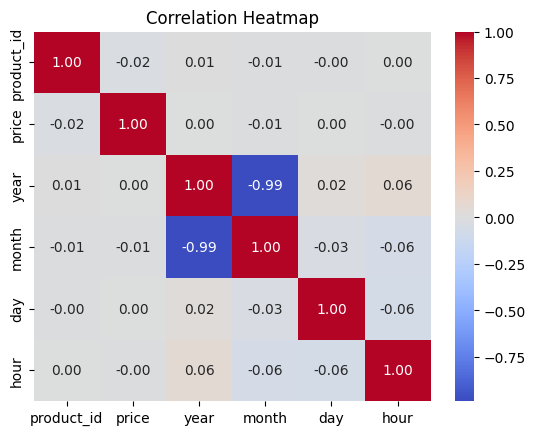

In [16]:
numeric_cols = cosmetics_event_filtered.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# interactive dashboard of the findings

In [17]:

df = cosmetics_event_filtered.copy()
df["year_month"] = df["year_month"].astype(str)

def show_dashboard(event_types, months, top_n):
    temp = df.copy()
    if event_types:
        temp = temp[temp["event_type"].isin(event_types)]
    if months:
        temp = temp[temp["year_month"].isin(months)]

    monthly = temp.groupby("year_month").size().reset_index(name="count")
    px.line(
        monthly, x="year_month", y="count",
        title=" Monthly Event Counts",
        markers=True,
        color_discrete_sequence=["#2b8cbe"]
    ).show()

    et = temp["event_type"].value_counts().reset_index()
    et.columns = ["event_type", "count"]
    px.bar(
        et, x="event_type", y="count",
        title=" Event Type Distribution",
        color="event_type",
        color_discrete_sequence=px.colors.sequential.Teal
    ).show()

    topb = temp["brand"].value_counts().head(top_n).reset_index()
    topb.columns = ["brand", "count"]
    px.bar(
        topb, x="brand", y="count",
        title=f" Top {top_n} Brands",
        color="count",
        color_continuous_scale=px.colors.sequential.Magma
    ).show()

    hourly = temp.groupby("hour").size().reset_index(name="count")
    px.bar(
        hourly, x="hour", y="count",
        title=" Events by Hour",
        color="count",
        color_continuous_scale=px.colors.sequential.Sunset
    ).show()

event_types_widget = widgets.SelectMultiple(
    options=sorted(df["event_type"].unique()),
    description="Event Types:",
    layout=Layout(width="300px")
)

months_widget = widgets.SelectMultiple(
    options=sorted(df["year_month"].unique()),
    description="Months:",
    layout=Layout(width="300px")
)

top_n_widget = widgets.IntSlider(
    value=15, min=5, max=30, step=5, description="Top N Brands:", style={"description_width": "initial"}
)

ui = VBox([
    HBox([event_types_widget, months_widget]),
    top_n_widget
])

out = widgets.interactive_output(
    show_dashboard,
    {'event_types': event_types_widget, 'months': months_widget, 'top_n': top_n_widget}
)

display(ui, out)


Output()

In [18]:
!pip uninstall -y prophet fbprophet


Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1


In [20]:
!pip install prophet --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 14.6 MB/s eta 0:00:00


In [18]:
from prophet import Prophet
import pandas as pd

# Convert event_time to datetime
cosmetics_event_combined_df['event_time'] = pd.to_datetime(cosmetics_event_combined_df['event_time'])

# Aggregate by day
daily_df = cosmetics_event_combined_df.groupby(
    [cosmetics_event_combined_df['event_time'].dt.year.rename('year'),
     cosmetics_event_combined_df['event_time'].dt.month.rename('month'),
     cosmetics_event_combined_df['event_time'].dt.day.rename('day')]
).size().reset_index(name='sales')

# Create date column
daily_df['date'] = pd.to_datetime(daily_df[['year', 'month', 'day']])
daily_df = daily_df[['date', 'sales']].sort_values('date')

# Split train/test if needed
train = daily_df.iloc[:-30]
test = daily_df.iloc[-30:]

# Prepare for Prophet
prophet_df = daily_df.rename(columns={'date': 'ds', 'sales': 'y'})

# Create and fit the model
model = Prophet()
model.fit(prophet_df)

# Make future dataframe and forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Optional: view forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
61,2020-03-03,143764.519449,106418.287053,184962.955061
62,2020-03-04,141156.131163,101736.467407,181662.569804
63,2020-03-05,124579.907889,86630.868892,163828.822994
64,2020-03-06,118811.581503,79849.650178,155870.445361
65,2020-03-07,119396.622981,80970.680912,157280.510458


In [19]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily_df[['sales']])

SEQ_LEN = 30
X, y = create_sequences(scaled, SEQ_LEN)


split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


X_train = X_train.reshape(X_train.shape[0], SEQ_LEN, 1)
X_test = X_test.reshape(X_test.shape[0], SEQ_LEN, 1)

model_lstm = Sequential([ LSTM(64, return_sequences=False, input_shape=(SEQ_LEN, 1)),  Dense(1)])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6739
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.6143
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.5579
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.5039
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4513
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3994
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3474
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2949
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2419
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1883
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1349
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0836
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0384
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0084
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0095
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━

In [20]:
model_bilstm = Sequential([ Bidirectional(LSTM(64, return_sequences=False), input_shape=(SEQ_LEN, 1)), Dense(1)])

model_bilstm.compile(optimizer='adam', loss='mse')
model_bilstm.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5022
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.3955
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2992
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2135
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1391
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0775
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0318
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0069
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0087
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0338
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0555
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0569
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0439
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0275
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0144
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━

In [21]:
model_gru = Sequential([GRU(64, return_sequences=False, input_shape=(SEQ_LEN, 1)), Dense(1)])

model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6225
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.5662
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.5128
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.4622
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4142
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3687
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.3256
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2848
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2462
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2097
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1756
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1437
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1143
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0875
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0637
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━

In [22]:
model_bigru = Sequential([Bidirectional(GRU(64, return_sequences=False), input_shape=(SEQ_LEN, 1)),Dense(1)])

model_bigru.compile(optimizer='adam', loss='mse')
model_bigru.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6580
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.5606
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.4721
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3919
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.3199
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2558
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1992
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1501
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1084
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0740
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0468
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0269
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0141
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0080
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0079
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━

In [23]:
model_cnn = Sequential([ Conv1D(64, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, 1)), Flatten(),Dense(32, activation='relu'),Dense(1)])

model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1790
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0068
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0674
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0655
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0243
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0048
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0107
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0228
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0266
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0201
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0097
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0028
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0029
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0076
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0114
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/s

In [24]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )


def forecast_accuracy(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mean_actual = np.mean(y_true)
    return 1 - (mae / mean_actual)


def evaluate_neural_model(model, X_test, y_test, scaler):

    pred = model.predict(X_test)
    pred = pred.reshape(-1, 1)


    pred_inv = scaler.inverse_transform(pred).reshape(-1)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)


    mae = mean_absolute_error(y_test_inv, pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
    r2 = r2_score(y_test_inv, pred_inv)
    acc = forecast_accuracy(y_test_inv, pred_inv)
    sm = smape(y_test_inv, pred_inv)

    return mae, rmse, r2, acc, sm



prophet_forecast = forecast['yhat'].tail(30).values
y_test_prophet = test['sales'].values

mae_p = mean_absolute_error(y_test_prophet, prophet_forecast)
rmse_p = np.sqrt(mean_squared_error(y_test_prophet, prophet_forecast))
r2_p = r2_score(y_test_prophet, prophet_forecast)
acc_p = forecast_accuracy(y_test_prophet, prophet_forecast)
smape_p = smape(y_test_prophet, prophet_forecast)


results = {}


results["Prophet"] = [mae_p, rmse_p, r2_p, acc_p, smape_p]


results["LSTM"] = list(evaluate_neural_model(model_lstm, X_test, y_test, scaler))


results["BiLSTM"] = list(evaluate_neural_model(model_bilstm, X_test, y_test, scaler))


results["GRU"] = list(evaluate_neural_model(model_gru, X_test, y_test, scaler))


results["BiGRU"] = list(evaluate_neural_model(model_bigru, X_test, y_test, scaler))


results["CNN"] = list(evaluate_neural_model(model_cnn, X_test, y_test, scaler))


comparison_df = pd.DataFrame.from_dict(results,orient='index',columns=["MAE", "RMSE", "R2", "Accuracy", "SMAPE"])

print(comparison_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
                  MAE          RMSE        R2  Accuracy      SMAPE
Prophet  19490.019441  27778.581163  0.111224  0.842966  17.619842
LSTM     36366.453125  43043.968566 -3.178409  0.740090  23.968324
BiLSTM   22532.718750  25028.173308 -0.412683  0.838959  16.078334
GRU      47480.054688  52917.622795 -5.315199  0.660662  29.927502
BiGRU    55596.664062  59971.165915 -7.110943  0.602652  34.050106
CNN      21603.703125  24977.768394 -0.406999  0.845599  15.455731


In [25]:
model_cnn_bigru = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(GRU(64, return_sequences=False)),Dense(32, activation='relu'),Dense(1)])

model_cnn_bigru.compile(optimizer='adam', loss='mse')
model_cnn_bigru.summary()


history_cnn_bigru = model_cnn_bigru.fit( X_train, y_train,epochs=20,batch_size=32,validation_split=0.1,verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 28, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.6994 - val_loss: 0.5704
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.5768 - val_loss: 0.4865
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.4926 - val_loss: 0.4255
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.4334 - val_loss: 0.3752
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3851 - val_loss: 0.3333
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3441 - val_loss: 0.2919
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.3006 - val_loss: 0.2462
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2537 - val_loss: 0.2005
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2062 - val_loss: 0.1551
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1614 - val_loss: 0.1121
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.1197 - val_loss: 0.0727
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.0815 - val_loss:

In [26]:
results["CNN+BiGRU"] = list(evaluate_neural_model(model_cnn_bigru, X_test, y_test, scaler))

comparison_df = pd.DataFrame.from_dict(results,orient='index',columns=["MAE", "RMSE", "R2", "Accuracy", "SMAPE"])

print(comparison_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
                    MAE          RMSE        R2  Accuracy      SMAPE
Prophet    19490.019441  27778.581163  0.111224  0.842966  17.619842
LSTM       36366.453125  43043.968566 -3.178409  0.740090  23.968324
BiLSTM     22532.718750  25028.173308 -0.412683  0.838959  16.078334
GRU        47480.054688  52917.622795 -5.315199  0.660662  29.927502
BiGRU      55596.664062  59971.165915 -7.110943  0.602652  34.050106
CNN        21603.703125  24977.768394 -0.406999  0.845599  15.455731
CNN+BiGRU  59082.468750  62348.694073 -7.766800  0.577740  35.788314


In [27]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


dashboard_preds_prophet = forecast[['ds', 'yhat']].tail(30)

In [28]:

preds = model_cnn_bigru.predict(X_test)
preds = scaler.inverse_transform(preds)  # if scaled

dashboard_preds_cnn_bigru = preds[-30:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [29]:

num_points = min(30, len(X_test))
cnn_bigru_preds_scaled = model_cnn_bigru.predict(X_test[-num_points:])
cnn_bigru_preds = scaler.inverse_transform(cnn_bigru_preds_scaled)


dashboard_preds_cnn_bigru = pd.DataFrame({
    'ds': df.index[-num_points:],
})

print(dashboard_preds_cnn_bigru)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
        ds
0  4601062
1  4601063


In [42]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import io
from PIL import Image

# Make sure to run this after loading your cosmetics_event_combined_df
# The dataframe should have columns: event_time, year, month, day, hour,
# event_type, brand, product_id, price

# Define the function BEFORE creating the Gradio interface
def generate_visualizations(day, month, year):
    """
    Generate visualizations based on selected date
    """
    try:
        # Convert to integers to avoid format issues
        day = int(day)
        month = int(month)
        year = int(year)

        # Create the target date
        target_date = pd.Timestamp(year=year, month=month, day=day)

        # Filter data for the selected date
        filtered_df = cosmetics_event_combined_df[
            (cosmetics_event_combined_df['year'] == year) &
            (cosmetics_event_combined_df['month'] == month) &
            (cosmetics_event_combined_df['day'] == day)
        ].copy()

        if filtered_df.empty:
            return None, f"❌ No data available for {year}-{month:02d}-{day:02d}"

        # Create figure with multiple subplots
        fig = plt.figure(figsize=(20, 12))

        # 1. Hourly Events Bar Chart
        ax1 = plt.subplot(2, 3, 1)
        hourly_events = filtered_df.groupby('hour').size().reset_index(name='count')
        sns.barplot(data=hourly_events, x='hour', y='count', ax=ax1, palette='viridis')
        ax1.set_title(f"Events by Hour - {year}-{month:02d}-{day:02d}", fontsize=14, fontweight='bold')
        ax1.set_xlabel("Hour of Day")
        ax1.set_ylabel("Number of Events")

        # 2. Event Type Distribution
        ax2 = plt.subplot(2, 3, 2)
        event_type_counts = filtered_df['event_type'].value_counts()
        sns.barplot(x=event_type_counts.index, y=event_type_counts.values, ax=ax2, palette="Set2")
        ax2.set_title("Event Type Distribution", fontsize=14, fontweight='bold')
        ax2.set_xlabel("Event Type")
        ax2.set_ylabel("Count")
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # 3. Top Brands
        ax3 = plt.subplot(2, 3, 3)
        top_brands = filtered_df['brand'].value_counts().head(10)
        if len(top_brands) > 0:
            sns.barplot(x=top_brands.values, y=top_brands.index, ax=ax3, palette="coolwarm")
            ax3.set_title("Top 10 Brands", fontsize=14, fontweight='bold')
            ax3.set_xlabel("Number of Events")
            ax3.set_ylabel("Brand")
        else:
            ax3.text(0.5, 0.5, 'No brand data', ha='center', va='center')
            ax3.set_title("Top 10 Brands", fontsize=14, fontweight='bold')

        # 4. Price Distribution
        ax4 = plt.subplot(2, 3, 4)
        filtered_price = filtered_df[
            (filtered_df['price'] >= 0) &
            (filtered_df['price'] <= 300)
        ]
        if len(filtered_price) > 0:
            sns.histplot(filtered_price['price'], bins=30, kde=True, ax=ax4, color='skyblue')
            ax4.set_title("Price Distribution", fontsize=14, fontweight='bold')
            ax4.set_xlabel("Price")
            ax4.set_ylabel("Frequency")
        else:
            ax4.text(0.5, 0.5, 'No price data', ha='center', va='center')
            ax4.set_title("Price Distribution", fontsize=14, fontweight='bold')

        # 5. Correlation Heatmap
        ax5 = plt.subplot(2, 3, 5)
        numeric_cols = filtered_df.select_dtypes(include=np.number)
        if not numeric_cols.empty and len(numeric_cols.columns) > 1:
            corr_matrix = numeric_cols.corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax5,
                       cbar_kws={'shrink': 0.8})
            ax5.set_title("Correlation Heatmap", fontsize=14, fontweight='bold')
        else:
            ax5.text(0.5, 0.5, 'Insufficient numeric data',
                    ha='center', va='center', fontsize=12)
            ax5.set_title("Correlation Heatmap", fontsize=14, fontweight='bold')

        # 6. Event Type by Hour Heatmap
        ax6 = plt.subplot(2, 3, 6)
        hour_event_pivot = filtered_df.groupby(['hour', 'event_type']).size().reset_index(name='count')
        hour_event_pivot = hour_event_pivot.pivot(index='event_type', columns='hour', values='count').fillna(0)
        if not hour_event_pivot.empty:
            sns.heatmap(hour_event_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax6,
                       cbar_kws={'shrink': 0.8})
            ax6.set_title("Event Type by Hour Heatmap", fontsize=14, fontweight='bold')
            ax6.set_xlabel("Hour")
            ax6.set_ylabel("Event Type")
        else:
            ax6.text(0.5, 0.5, 'No data available',
                    ha='center', va='center', fontsize=12)
            ax6.set_title("Event Type by Hour Heatmap", fontsize=14, fontweight='bold')

        plt.tight_layout()

        # Save figure to buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        img = Image.open(buf)
        plt.close()

        # Generate summary statistics
        summary = f"""
📊 **Summary Statistics for {year:d}-{month:02d}-{day:02d}**

- **Total Events:** {len(filtered_df):,}
- **Unique Products:** {filtered_df['product_id'].nunique():,}
- **Unique Brands:** {filtered_df['brand'].nunique():,}
- **Average Price:** ${filtered_df['price'].mean():.2f}
- **Price Range:** ${filtered_df['price'].min():.2f} - ${filtered_df['price'].max():.2f}

**Event Type Breakdown:**
```
{event_type_counts.to_string()}
```

**Peak Hour:** {int(hourly_events.loc[hourly_events['count'].idxmax(), 'hour']):02d}:00
({int(hourly_events['count'].max())} events)
        """

        return img, summary

    except Exception as e:
        return None, f"❌ **Error:** {str(e)}\n\nPlease make sure the data is loaded correctly."


# Create Gradio Interface
with gr.Blocks(theme=gr.themes.Soft(), title="Cosmetics Event Dashboard") as demo:
    gr.Markdown(
        """
        # 🛍️ Cosmetics E-commerce Event Dashboard
        Select a date to view detailed analytics and visualizations
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            day_input = gr.Slider(
                minimum=1,
                maximum=31,
                step=1,
                value=1,
                label="Day"
            )
            month_input = gr.Slider(
                minimum=1,
                maximum=12,
                step=1,
                value=1,
                label="Month"
            )
            year_input = gr.Slider(
                minimum=2019,
                maximum=2020,
                step=1,
                value=2019,
                label="Year"
            )
            analyze_btn = gr.Button("🔍 Analyze Date", variant="primary", size="lg")

        with gr.Column(scale=2):
            summary_output = gr.Markdown(label="Summary Statistics")

    with gr.Row():
        visualization_output = gr.Image(label="Visualizations", type="pil")

    # Set up the button click event
    analyze_btn.click(
        fn=generate_visualizations,
        inputs=[day_input, month_input, year_input],
        outputs=[visualization_output, summary_output]
    )

    gr.Markdown(
        """
        ---
        ### 📈 Available Visualizations:
        1. **Hourly Events Bar Chart** - Activity patterns throughout the day
        2. **Event Type Distribution** - View, cart, and purchase actions
        3. **Top 10 Brands** - Most popular brands for the selected date
        4. **Price Distribution** - Product price analysis
        5. **Correlation Heatmap** - Relationships between numeric features
        6. **Event Type by Hour** - Detailed heatmap of activities by time
        """
    )

# Launch the interface
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a82163150464ee0967.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
